# 3. Machine Learning for Classification

We'll use logistic regression to predict churn


## 3.1 Churn prediction project

* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Data preparation

In [43]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce').fillna(0)
df.churn = (df.churn == 'yes').astype(int)

## Setting up the validation framework
Perform the train/validation/test split with Scikit-Learn

In [44]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']


## EDA
Check missing values
Look at the target variable (churn)
Look at numerical and categorical variables

In [45]:
df_full_train = df_full_train.reset_index(drop=True)

df_full_train.isnull().sum()

df_full_train.churn.value_counts(normalize=True)
'''should be the same'''
df_full_train.churn.mean()

numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature importance: Churn rate and risk ratio
Feature importance analysis (part of EDA) - identifying which features affect our target variable

Churn rate
Risk ratio
Mutual information - later

### Churn rate

In [46]:
global_churn = df_full_train.churn.mean()

churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()

global_churn - churn_female
global_churn - churn_male
'''not so much different'''

churn_partner = df_full_train[df_full_train.partner == 'yes'].churn.mean()
global_churn - churn_partner

churn_no_partner = df_full_train[df_full_train.partner == 'no'].churn.mean()
global_churn - churn_no_partner

'''Churn rate is higher in group without partner'''

'Churn rate is higher in group without partner'

### Risk ratio

In [47]:
churn_no_partner / global_churn
churn_partner / global_churn



0.7594724924338315

SELECT
    gender,
    AVG(churn),
    AVG(churn) - global_churn AS diff,
    AVG(churn) / global_churn AS risk
FROM
    data
GROUP BY
    gender;

In [49]:
from IPython.display import display

for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()

gender


mean  count      diff      risk
gender                                     
female  0.276824   2796  0.006856  1.025396
male    0.263214   2838 -0.006755  0.974980



seniorcitizen


mean  count      diff      risk
seniorcitizen                                     
0              0.242270   4722 -0.027698  0.897403
1              0.413377    912  0.143409  1.531208



partner


mean  count      diff      risk
partner                                     
no       0.329809   2932  0.059841  1.221659
yes      0.205033   2702 -0.064935  0.759472



dependents


mean  count      diff      risk
dependents                                     
no          0.313760   3968  0.043792  1.162212
yes         0.165666   1666 -0.104302  0.613651



phoneservice


mean  count      diff      risk
phoneservice                                     
no            0.241316    547 -0.028652  0.893870
yes           0.273049   5087  0.003081  1.011412



multiplelines


mean  count      diff      risk
multiplelines                                        
no                0.257407   2700 -0.012561  0.953474
no_phone_service  0.241316    547 -0.028652  0.893870
yes               0.290742   2387  0.020773  1.076948



internetservice


mean  count      diff      risk
internetservice                                     
dsl              0.192347   1934 -0.077621  0.712482
fiber_optic      0.425171   2479  0.155203  1.574895
no               0.077805   1221 -0.192163  0.288201



onlinesecurity


mean  count      diff      risk
onlinesecurity                                          
no                   0.420921   2801  0.150953  1.559152
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.153226   1612 -0.116742  0.567570



onlinebackup


mean  count      diff      risk
onlinebackup                                            
no                   0.404323   2498  0.134355  1.497672
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.217232   1915 -0.052736  0.804660



deviceprotection


mean  count      diff      risk
deviceprotection                                        
no                   0.395875   2473  0.125907  1.466379
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.230412   1940 -0.039556  0.853480



techsupport


mean  count      diff      risk
techsupport                                             
no                   0.418914   2781  0.148946  1.551717
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.159926   1632 -0.110042  0.592390



streamingtv


mean  count      diff      risk
streamingtv                                             
no                   0.342832   2246  0.072864  1.269897
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.302723   2167  0.032755  1.121328



streamingmovies


mean  count      diff      risk
streamingmovies                                         
no                   0.338906   2213  0.068938  1.255358
no_internet_service  0.077805   1221 -0.192163  0.288201
yes                  0.307273   2200  0.037305  1.138182



contract


mean  count      diff      risk
contract                                           
month-to-month  0.431701   3104  0.161733  1.599082
one_year        0.120573   1186 -0.149395  0.446621
two_year        0.028274   1344 -0.241694  0.104730



paperlessbilling


mean  count      diff      risk
paperlessbilling                                     
no                0.172071   2313 -0.097897  0.637375
yes               0.338151   3321  0.068183  1.252560



paymentmethod


mean  count      diff      risk
paymentmethod                                                 
bank_transfer_(automatic)  0.168171   1219 -0.101797  0.622928
credit_card_(automatic)    0.164339   1217 -0.105630  0.608733
electronic_check           0.455890   1893  0.185922  1.688682
mailed_check               0.193870   1305 -0.076098  0.718121

## Feature importance: Mutual information
Mutual information - concept from information theory, it tells us how much we can learn about one variable if we know the value of another

https://en.wikipedia.org/wiki/Mutual_information

In [50]:
from sklearn.metrics import mutual_info_score

mutual_info_score(df_full_train.churn, df_full_train.contract)



0.0983203874041556

In [51]:
mutual_info_score(df_full_train.churn, df_full_train.gender)


0.0001174846211139946

In [52]:
mutual_info_score(df_full_train.churn, df_full_train.partner)

0.009967689095399745

In [53]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)

mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

## Feature importance: Correlation
How about numerical columns?

Correlation coefficient - https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

In [54]:
df_full_train.tenure.max()


72

In [55]:
df_full_train[numerical].corrwith(df_full_train.churn).abs().sort_values(ascending=False)

tenure            0.351885
monthlycharges    0.196805
totalcharges      0.196353
dtype: float64

In [56]:
df_full_train[df_full_train.tenure <= 2].churn.mean()

0.5953420669577875

In [57]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

0.3994413407821229

In [58]:
df_full_train[df_full_train.tenure > 12].churn.mean()

0.17634908339788277

In [59]:
df_full_train[df_full_train.monthlycharges <= 20].churn.mean()

0.08795411089866156

In [60]:
df_full_train[(df_full_train.monthlycharges > 20) & (df_full_train.monthlycharges <= 50)].churn.mean()

0.18340943683409436

In [61]:
df_full_train[df_full_train.monthlycharges > 50].churn.mean()


0.32499341585462205

## One-hot encoding
Use Scikit-Learn to encode categorical features

In [62]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
print (X_train)
print (dv.get_feature_names())


val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
print (X_val)

[[0.00000e+00 0.00000e+00 1.00000e+00 ... 1.00000e+00 7.20000e+01
  8.42515e+03]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 1.00000e+01
  1.02155e+03]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 5.00000e+00
  4.13650e+02]
 ...
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 1.00000e+00 2.00000e+00
  1.90050e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00 ... 0.00000e+00 2.70000e+01
  7.61950e+02]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 9.00000e+00
  7.51650e+02]]
['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'dependents=no', 'dependents=yes', 'deviceprotection=no', 'deviceprotection=no_internet_service', 'deviceprotection=yes', 'gender=female', 'gender=male', 'internetservice=dsl', 'internetservice=fiber_optic', 'internetservice=no', 'monthlycharges', 'multiplelines=no', 'multiplelines=no_phone_service', 'multiplelines=yes', 'onlinebackup=no', 'onlinebackup=no_internet_service', 'onlinebackup=yes', 'onlinesecurity=no', 'onlinesecurity=no_

## Logistic regression
Binary classification
Linear vs logistic regression

In [63]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [64]:
z = np.linspace(-5, 5, 51)
sigmoid(-100)

3.7200759760208356e-44

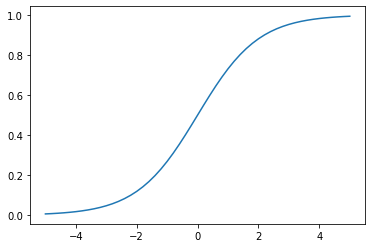

In [65]:
plt.plot(z, sigmoid(z))

In [66]:
def linear_regression(x1):
    result = w0
    for j in range(len(w)):
        result = result + xi[j] * w[j]
    return result

In [67]:
def logistic_regression(xi):
    score = w0
    for j in range(len(w)):
        score = score + xi[j] * w[j]
        
    return sigmoid(score)

## Training logistic regression with Scikit-Learn
Train a model with Scikit-Learn
Apply it to the validation dataset
Calculate the accuracy

In [68]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression()

In [69]:
model.intercept_[0]

-0.10900244057223585

In [70]:
model.coef_[0].round(3)

array([ 0.475, -0.175, -0.408, -0.03 , -0.078,  0.063, -0.089, -0.081,
       -0.034, -0.073, -0.335,  0.317, -0.089,  0.004, -0.258,  0.141,
        0.009,  0.063, -0.089, -0.081,  0.266, -0.089, -0.284, -0.231,
        0.124, -0.166,  0.058, -0.087, -0.032,  0.071, -0.059,  0.141,
       -0.249,  0.216, -0.12 , -0.089,  0.102, -0.071, -0.089,  0.052,
        0.213, -0.089, -0.232, -0.07 ,  0.   ])

In [71]:
model.predict_proba(X_train)[:, 1]

array([0.09554777, 0.67936716, 0.63368002, ..., 0.53149623, 0.04252972,
       0.6987981 ])

In [72]:
y_pred = model.predict_proba(X_val)[:, 1]

In [73]:
(y_val == churn_decision).mean()

0.8034066713981547

In [74]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val

In [75]:
df_pred['correct'] = df_pred.prediction == df_pred.actual

In [76]:
df_pred.correct.mean()

0.8034066713981547

In [77]:
churn_decision = (y_pred >= 0.5)
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1])

In [78]:
churn_decision

array([False, False, False, ..., False,  True,  True])

## Model interpretation
Look at the coefficients
Train a smaller model with fewer features

In [79]:
a = [1, 2, 3, 4]
b = 'abcd'
dict(zip(a, b))

{1: 'a', 2: 'b', 3: 'c', 4: 'd'}

In [80]:
dict(zip(dv.get_feature_names(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.073,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.258,
 'multiplelines=no_phone_service': 0.141,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.124,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.071,


In [90]:
small = ['contract', 'tenure', 'monthlycharges']

dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

dv_small = DictVectorizer(sparse=False)

X_train_small = dv_small.fit_transform(dicts_train_small)
model_small = LogisticRegression(solver='lbfgs')
model_small.fit(X_train_small, y_train)

w0 = model_small.intercept_[0]
print("w0: {0}".format(w0))

w = model_small.coef_[0]
print("w: {0}".format(w.round(3)))

dict(zip(dv_small.get_feature_names(), w.round(3)))

w0: -2.4767756600387165
w: [ 0.97  -0.025 -0.949  0.027 -0.036]


{'contract=month-to-month': 0.97,
 'contract=one_year': -0.025,
 'contract=two_year': -0.949,
 'monthlycharges': 0.027,
 'tenure': -0.036}

In [104]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [105]:
sigmoid(_)

0.030090303318277657

## Using the model

In [106]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

y_full_train = df_full_train.churn.values

model = LogisticRegression(solver='lbfgs')
model.fit(X_full_train, y_full_train)

LogisticRegression()

In [107]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')

X_test = dv.transform(dicts_test)
y_pred = model.predict_proba(X_test)[:, 1]
churn_decision = (y_pred >= 0.5)
(churn_decision == y_test).mean()
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [108]:
customer = dicts_test[-1]
customer


{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [109]:
X_small = dv.transform([customer])
model.predict_proba(X_small)[0, 1]


0.5968852088419566

In [110]:
y_test[-1]


1